In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform
from PIL import Image
import numpy as np
import imageio
import skimage
import glob

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10
20
30
40
50
60
70
80
90
100


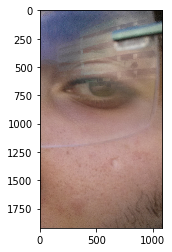

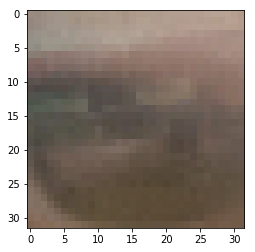

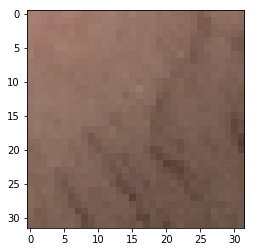

110
120
130
140
150
160
170
180
190
200


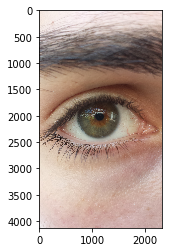

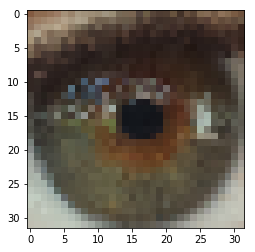

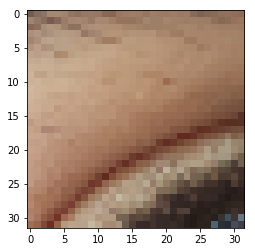

210
220
230
240
250
260
270
280
290
300


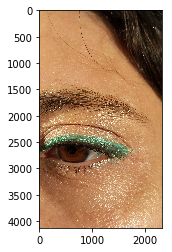

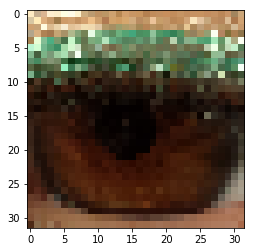

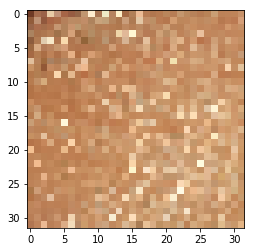

310
320
330
340
350
360
370
380
390
400


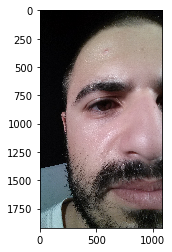

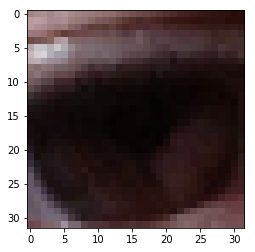

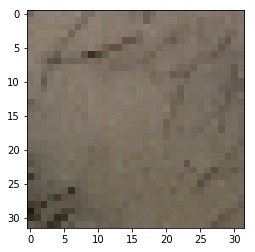

410
420
430
440
450
460
470
480
490
500


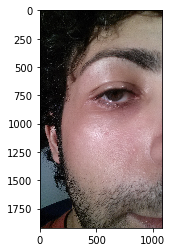

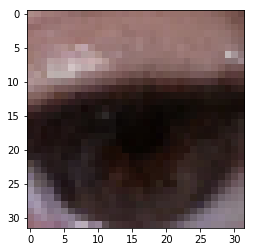

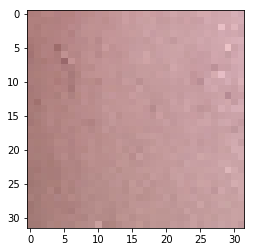

510
520
530
540
550
560
570
580
590
600


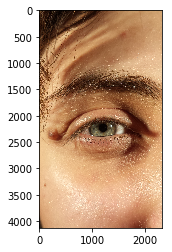

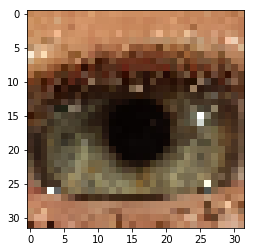

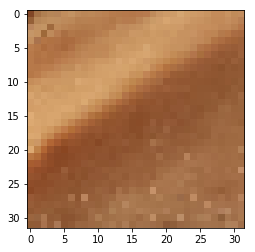

610
620
630
640
650
660
670
680
690
700


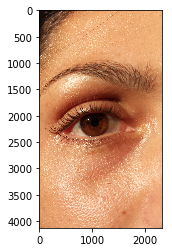

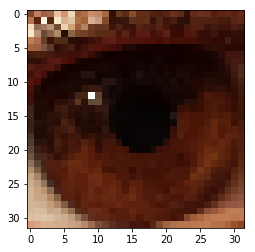

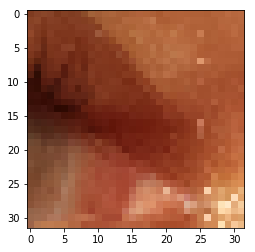

710
720
730
740
750
760
770
780
790
800


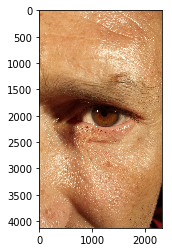

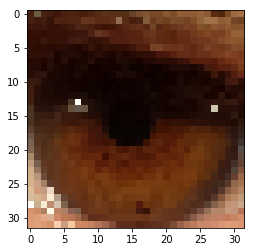

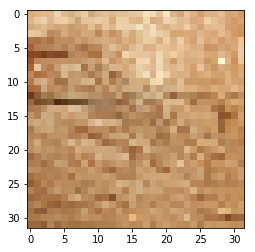

810
820
830
840
850
860
870
880
890
900


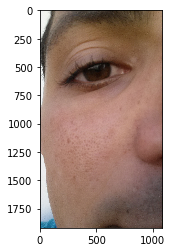

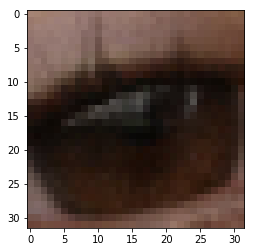

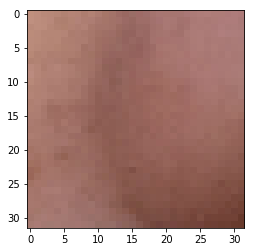

910
920
930
940
950
960
970
980
990
1000


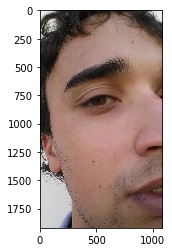

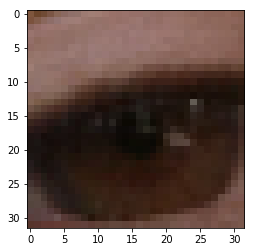

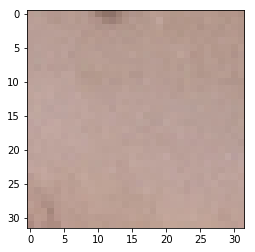

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


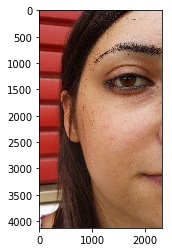

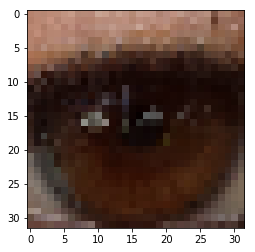

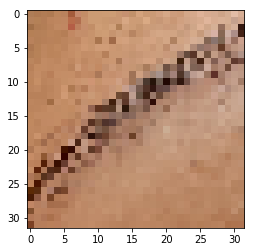

1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


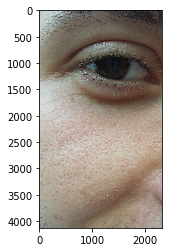

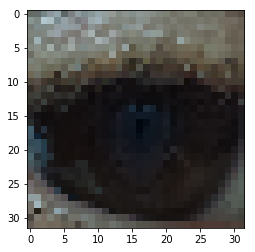

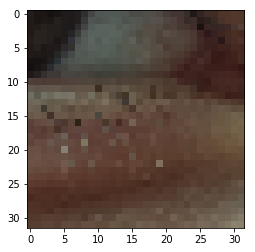

1210
1220
1230
1240
1250
1260
1270
1280
1290
(9079, 32, 32, 3)
(9079,)


In [3]:
def load_pics():
    
    X = []
    Y = []
    test_set_images = []
    test_set_truths = []
    num_falses_per_true = 6
    f = open('micheI_sgs4.txt')
       
    counter = 0
    for idx, l in enumerate(f):
        
        l = l.strip().split(' ')
        name, y, x, r = l[0], int(l[1]), int(l[2]), int(l[3])
        pic = imageio.imread('SamsungGalaxyS4/' + name + '.jpg')
        h, w, c = pic.shape
        
        if idx >= 907:
            scale_factor = 160.0/h
            pic_small = skimage.transform.resize(pic, (160,90,3))
            new_r = int(r * scale_factor)
            new_x = int(x * scale_factor)
            new_y = int(y * scale_factor)
            test_set_images.append(pic_small)
            test_set_truths.append((new_r, new_x, new_y))
        
        iris = pic[x-r:x+r,y-r:y+r,:]
        iris_scale = skimage.transform.resize(iris, (32,32,3))  
        X.append(iris_scale)
        Y.append(1)
       
        for _ in range(num_falses_per_true):
            corner_x = np.random.randint(0, h - 2*r)
            corner_y = np.random.randint(0, w - 2*r)
            while abs(corner_x - (x-r)) < r and abs(corner_y - (y-r)) < r:
                corner_x = np.random.randint(0, h - r)
                corner_y = np.random.randint(0, w - r)
        
            not_iris = pic[corner_x:corner_x+2*r, corner_y:corner_y+2*r,:]
            not_iris_scale = skimage.transform.resize(not_iris, (32,32,3))
        
            X.append(not_iris_scale)
            Y.append(0)
        
        counter += 1
        if counter % 10 == 0:
            print(counter)
           
        if counter % 100 == 0:
            plt.imshow(pic)
            plt.show()
            plt.imshow(iris_scale)
            plt.show()
            plt.imshow(not_iris_scale)
            plt.show()
    
    return (test_set_images, test_set_truths, np.array(X), np.array(Y))

test_set_images, test_set_truths, X, Y = load_pics()
print(X.shape)
print(Y.shape)

In [4]:
X = X.reshape((X.shape[0], 1, X.shape[3], X.shape[1], X.shape[2]))
Y = Y.reshape(Y.shape[0], 1, 1)

In [5]:
N = X.shape[0]
train = int(6*N/10)
val = int(7*N/10)

X_train = X[:train]
X_val = X[train:val]
X_test = X[val:]

y_train = Y[:train]
y_val = Y[train:val]
y_test = Y[val:]

X_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_val = torch.tensor(y_val)

X_test = torch.tensor(X_test).type(torch.FloatTensor)
y_test = torch.tensor(y_test)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

torch.Size([5447, 1, 3, 32, 32])
torch.Size([5447, 1, 1])
torch.Size([908, 1, 3, 32, 32])
torch.Size([908, 1, 1])
torch.Size([2724, 1, 3, 32, 32])
torch.Size([2724, 1, 1])


In [6]:
def check_accuracy_part34(mode, model, verbose=False):
            
    if mode == 'val':
        X_sel = X_val
        y_sel = y_val
    elif mode == 'train':
        X_sel = X_train
        y_sel = y_train
    else:
        X_sel = X_test
        y_sel = y_test
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            preds = 1 if model(x).item() > 0.5 else 0
            num_correct += (preds == y.item())
            if verbose and y.item() != preds:
                plt.imshow(np.array(x.detach())[0].reshape((32,32,3)))
                plt.show()
            num_samples += 1
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))

In [7]:
def train_part34(model, optimizer, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_train[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            scores = model(x)
            loss = F.binary_cross_entropy(scores, y)
            #print((y.item(), scores.item(), loss.item()))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model)
        check_accuracy_part34('val', model)
        print() 

In [8]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [10]:
channel_1 = 32
channel_2 = 16

model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
train_part34(model, optimizer, epochs=10)

Iteration 0, loss = 0.6685

Iteration 500, loss = 0.1415

Iteration 1000, loss = 0.0851

Iteration 1500, loss = 0.0252

Iteration 2000, loss = 0.0783

Iteration 2500, loss = 0.0229

Iteration 3000, loss = 0.0267

Iteration 3500, loss = 1.6736

Iteration 4000, loss = 0.0294

Iteration 4500, loss = 0.0038

Iteration 5000, loss = 0.2988

epoch 0
Got 4945 / 5447 correct (90.78) for mode train
Got 845 / 908 correct (93.06) for mode val

Iteration 0, loss = 1.2488

Iteration 500, loss = 0.0069

Iteration 1000, loss = 0.0250

Iteration 1500, loss = 0.0001

Iteration 2000, loss = 0.0020

Iteration 2500, loss = 0.0001

Iteration 3000, loss = 0.0000

Iteration 3500, loss = 0.7601

Iteration 4000, loss = 0.0007

Iteration 4500, loss = 0.0001

Iteration 5000, loss = 0.1835

epoch 1
Got 5033 / 5447 correct (92.40) for mode train
Got 862 / 908 correct (94.93) for mode val

Iteration 0, loss = 0.6818

Iteration 500, loss = 0.0007

Iteration 1000, loss = 0.0069

Iteration 1500, loss = 0.0000

Iteratio

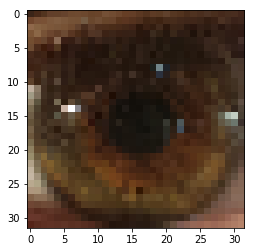

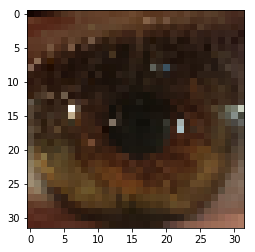

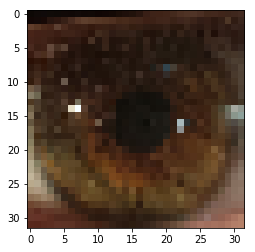

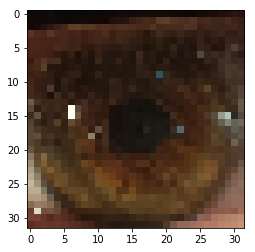

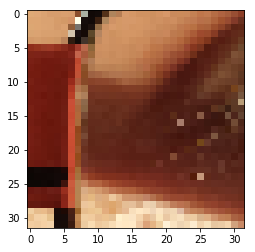

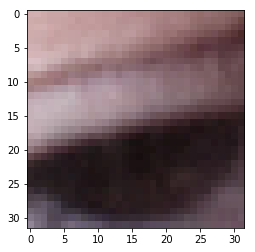

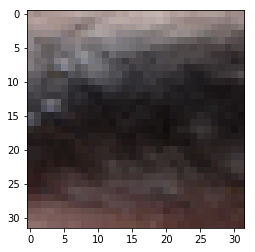

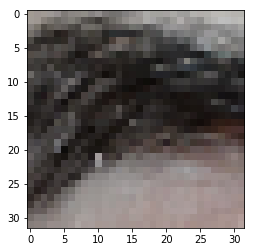

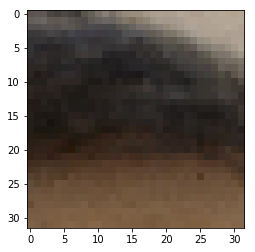

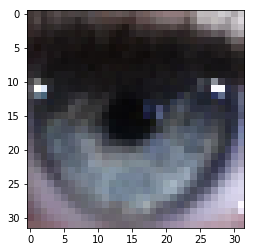

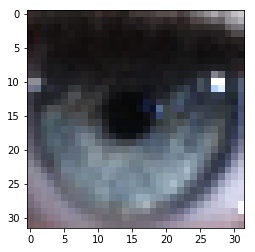

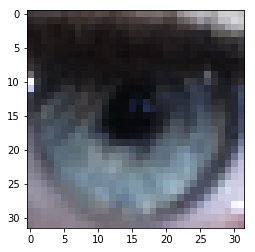

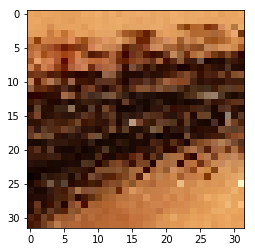

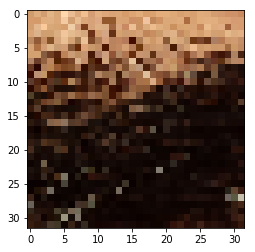

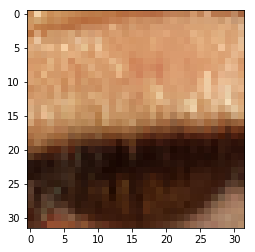

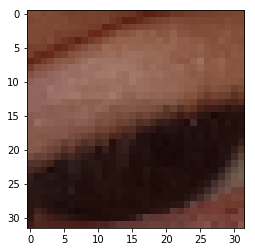

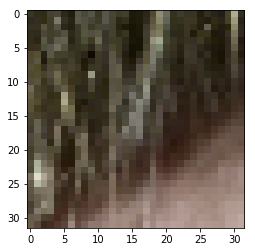

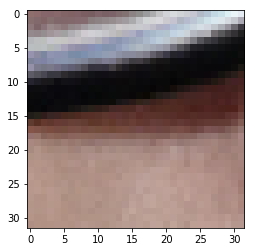

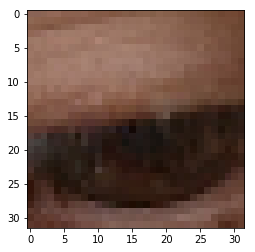

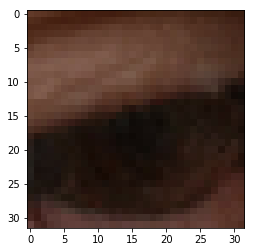

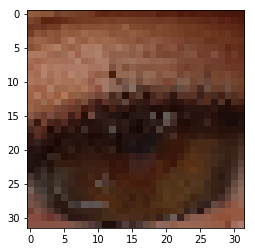

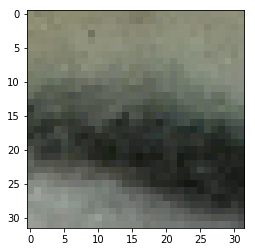

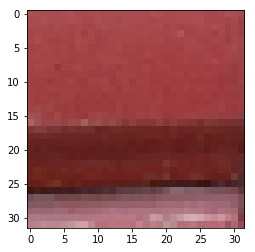

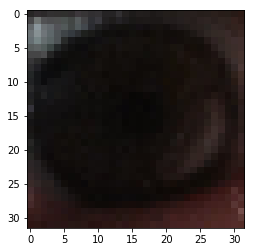

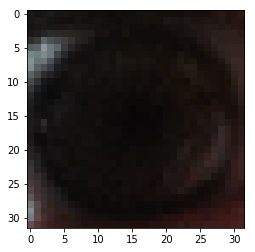

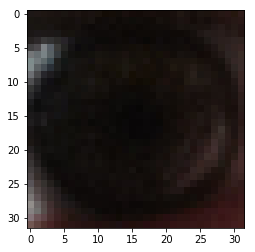

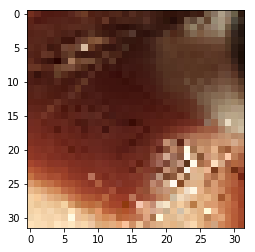

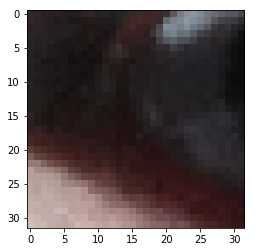

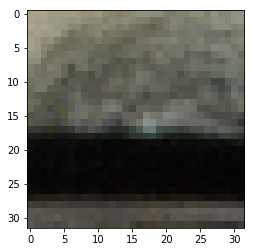

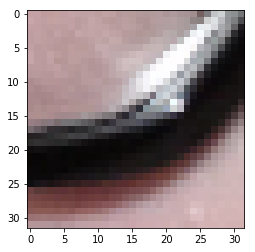

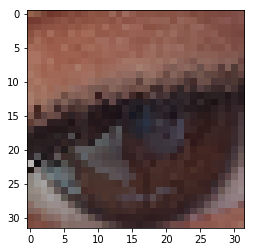

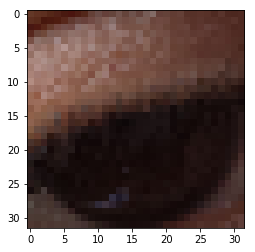

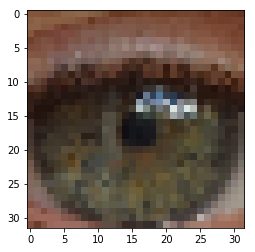

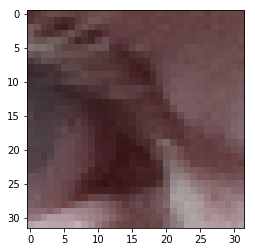

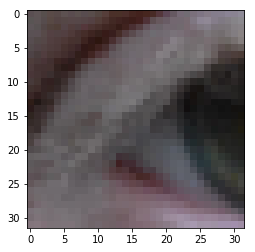

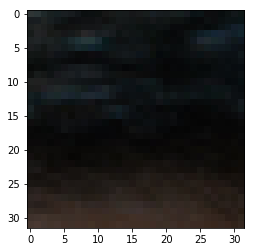

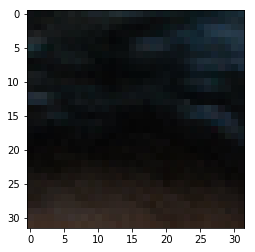

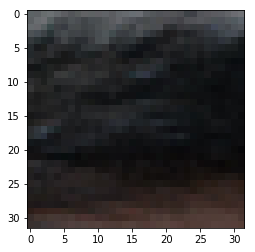

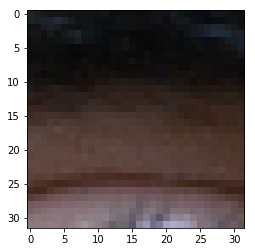

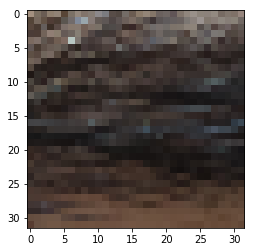

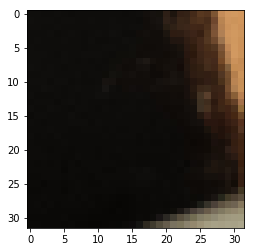

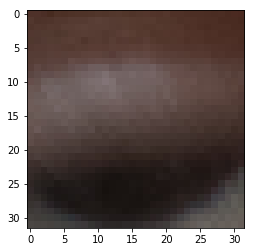

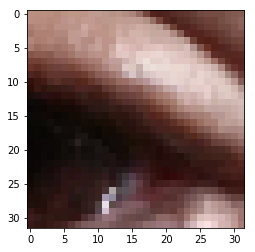

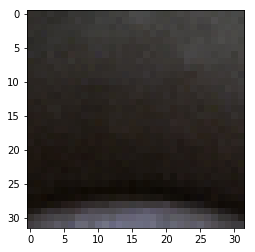

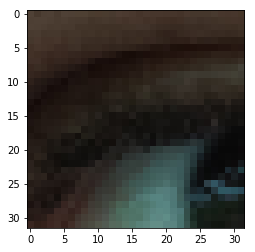

Got 2679 / 2724 correct (98.35) for mode test


In [ ]:
check_accuracy_part34('test', model, True)

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


23.08679276123039


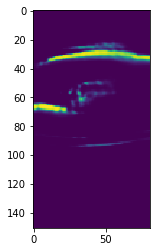

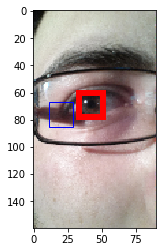

23.769728648009426


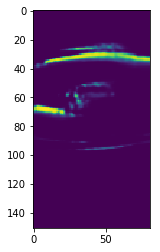

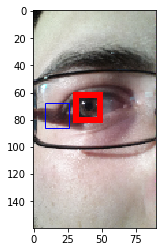

60.959002616512684


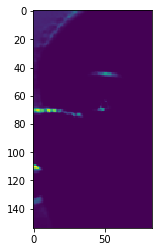

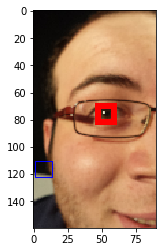

20.09975124224178


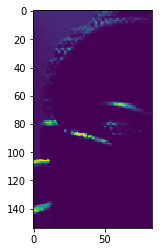

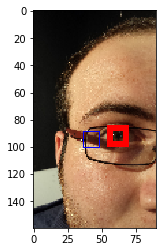

32.7566787083184


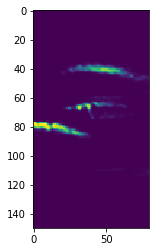

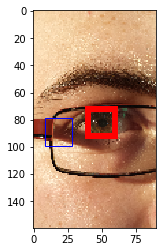

38.47076812334269


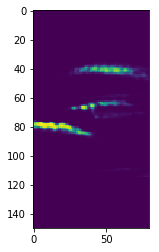

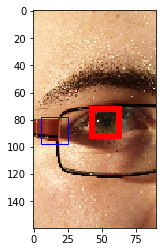

33.95585369269929


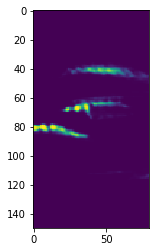

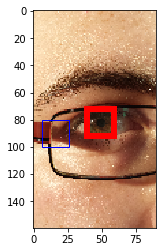

33.95585369269929


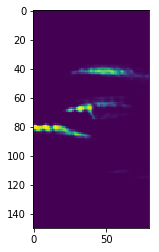

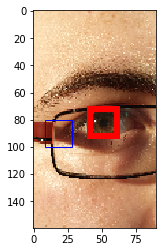

39.56008088970496


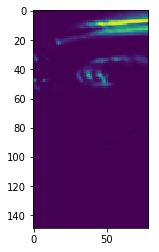

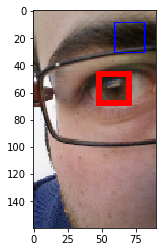

43.08131845707603


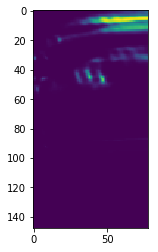

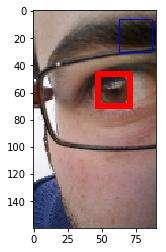

44.598206241955516


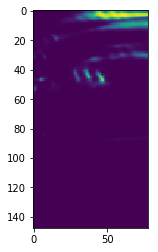

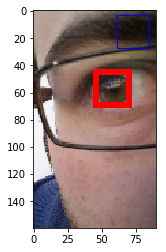

46.486557196677836


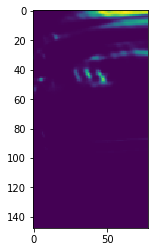

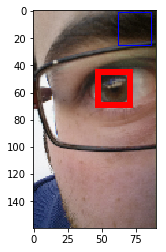

1.0


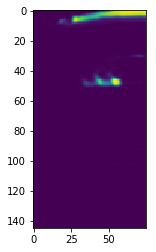

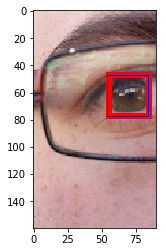

1.0


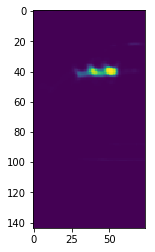

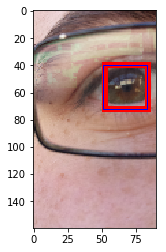

1.0


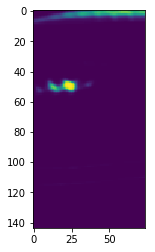

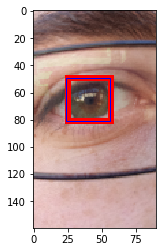

1.0


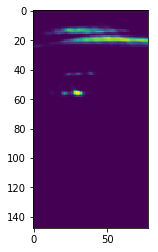

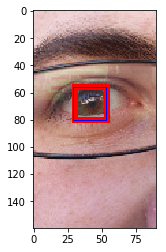

1.0


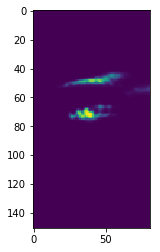

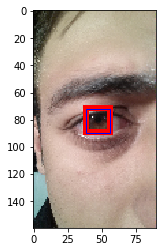

23.08679276123039


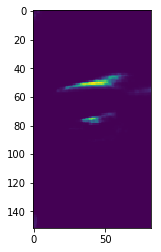

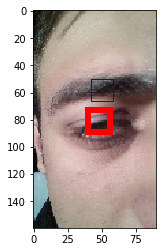

0.0


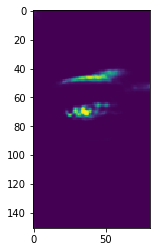

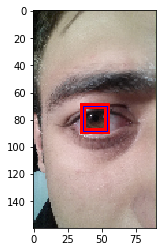

0.0


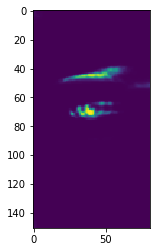

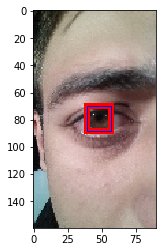

0.0


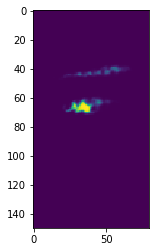

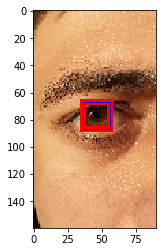

0.0


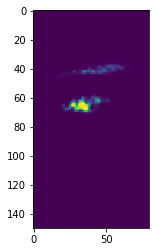

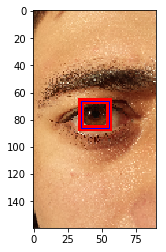

0.0


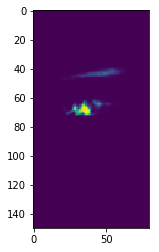

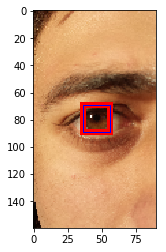

3.1622776601683795


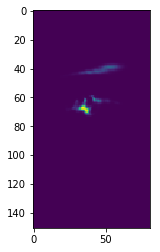

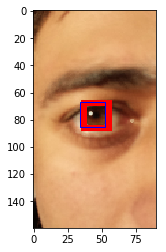

2.8284271247461903


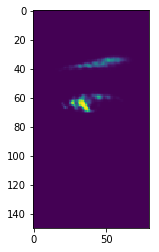

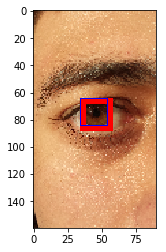

2.8284271247461903


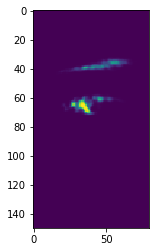

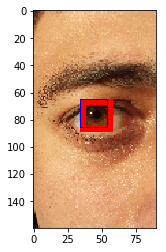

0.0


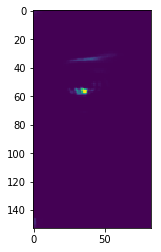

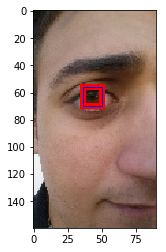

0.0


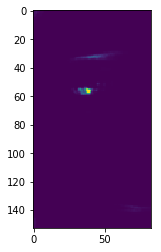

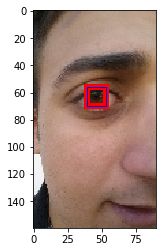

1.0


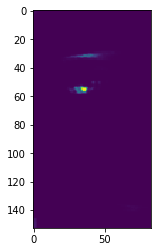

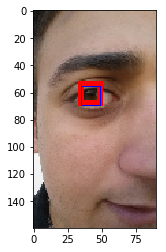

0.0


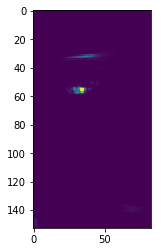

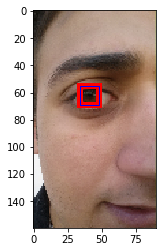

1.0


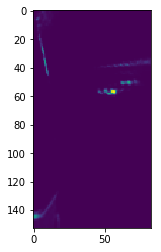

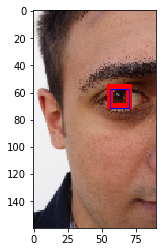

1.0


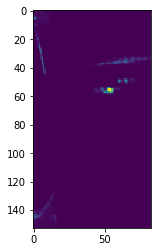

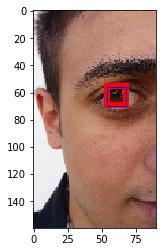

1.4142135623730951


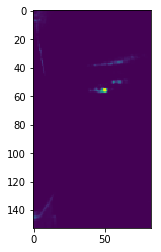

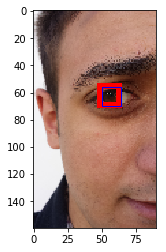

In [ ]:
f = open('micheI_sgs4.txt')
dist = []
for image_idx, pic_small in enumerate(test_set_images):
    
    (new_r, new_x, new_y) = test_set_truths[image_idx]
    scores = np.zeros((160-new_r,90-new_r))
    for ic, i in enumerate(range(160-new_r)):
        for jc, j in enumerate(range(90-new_r)):
            model_in = skimage.transform.resize(pic_small[i:i+2*new_r,j:j+2*new_r,:], (32,32,3))
            score = model(torch.tensor(model_in.reshape((1, 3, 32, 32))).type(torch.FloatTensor))
            scores[ic,jc] = score.item()
            
    c_x, c_y = np.unravel_index(np.argmax(scores), scores.shape)
    dist.append(np.sqrt((c_y - (new_y - new_r))**2 + (c_x - (new_x - new_r))**2))
    print(dist[-1])
    if image_idx % 1 == 0:
        plt.imshow(scores)
        fig, ax = plt.subplots(1)
        plt.imshow(pic_small)
        rect_true = patches.Rectangle((new_y-new_r,new_x-new_r),2*new_r,2*new_r, linewidth=6, edgecolor='r', facecolor='none')
        rect_pred = patches.Rectangle((c_y, c_x), 2*new_r, 2*new_r, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect_true)
        ax.add_patch(rect_pred)
        plt.show()
    
plt.hist(np.array(dist))
plt.show()